In [31]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.append(os.path.abspath('..'))
from processamento import df, categorical_cols, numeric_cols

In [19]:
# Considerar apenas Southern Europe
df_southern = df[df['Region'] == 'Southern Europe']

# Variáveis de interesse
X = df_southern[['Affected_Population']].values 
y = df_southern['Premature_Deaths'].values      

## 4.2.2 Modelos de regressão linear simples para prever mortes prematuras

#### Treino do modelo linear com K-Fold Cross Validation e função linear

In [20]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = LinearRegression()

mae_scores = []
rmse_scores = []
coefs = []
intercepts = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)

print("a) Função linear média resultante:")
print(f"y = {np.mean(coefs):.6f} * X + {np.mean(intercepts):.4f}")

a) Função linear média resultante:
y = 0.000383 * X + -13.8409


#### Visualização: reta da regressão + diagrama de dispersão

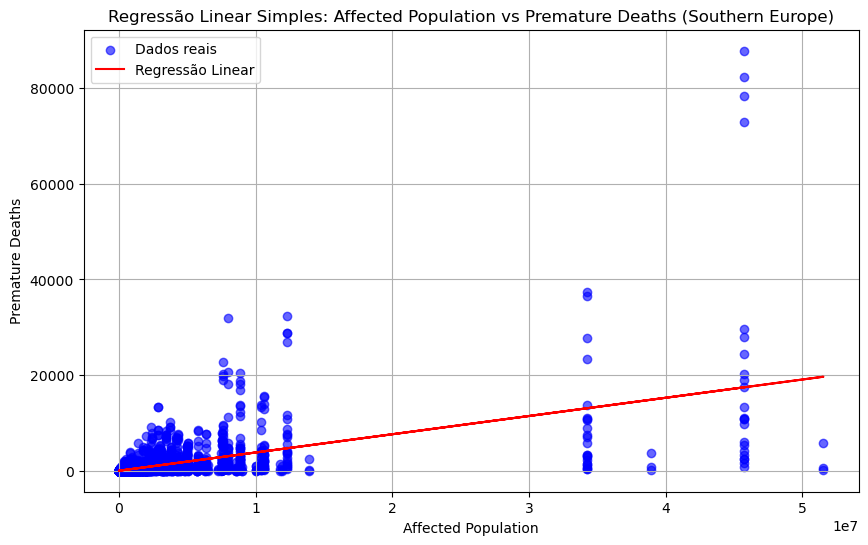

In [21]:
# Ajustar no conjunto total para visualização
model.fit(X, y)
y_pred_all = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Dados reais', alpha=0.6)
plt.plot(X, y_pred_all, color='red', label='Regressão Linear')
plt.xlabel('Affected Population')
plt.ylabel('Premature Deaths')
plt.title('Regressão Linear Simples: Affected Population vs Premature Deaths (Southern Europe)')
plt.legend()
plt.grid(True)
plt.show()

#### Cálculo final de MAE e RMSE médios (validação cruzada)

In [22]:
print("c) Erro Médio Absoluto (MAE): {:.2f}".format(np.mean(mae_scores)))
print("   Raiz do Erro Quadrático Médio (RMSE): {:.2f}".format(np.mean(rmse_scores)))

c) Erro Médio Absoluto (MAE): 432.29
   Raiz do Erro Quadrático Médio (RMSE): 1972.63


## 4.2.3 Desenvolva modelos para prever mortes prematuras (Premature_Deaths)

In [3]:
# Filtragem por paises de interesse: Southern Europe
countries_of_interest = ['Greece', 'Spain', 'Italy', 'Portugal']
df_4_2_3 = df[df['Country'].isin(countries_of_interest)]
df_4_2_3.reset_index(drop=True, inplace=True)

# Definir X e y filtragem
X = df_4_2_3.drop(columns=['Premature_Deaths'])
y = df_4_2_3['Premature_Deaths']

# Dividir os dados em conjuntos de treino e teste com KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols), # Normalização das colunas numéricas
        ('cat', OneHotEncoder(), categorical_cols) # Codificação das colunas categóricas
    ]
)

### a) Regressão linear múltipla.

In [5]:
# Regressão Linear Múltipla
model_lr = LinearRegression()

# Criar o pipeline para o modelo de Regressão Linear Múltipla
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lr)
])

# Listas para armazenar as métricas e resíduos
mae_lr, rmse_lr, r2_lr, residuals_lr = [], [], [], []

In [6]:
# Treinar e avaliar o modelo de Regressão Linear Múltipla com KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline_lr.fit(X_train, y_train)
    y_pred = pipeline_lr.predict(X_test)
    mae_lr.append(mean_absolute_error(y_test, y_pred))
    rmse_lr.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_lr.append(r2_score(y_test, y_pred))
    residuals_lr.append(y_test - y_pred)

# Exibir resultados em formato de tabela
print(f"{'\nModelo':<30}{'MAE':>10}{'RMSE':>10}{'R2':>10}")
print(f"{'Multiple Linear Regression':<30}{np.mean(mae_lr):>10.2f}{np.mean(rmse_lr):>10.2f}{np.mean(r2_lr):>10.2f}")

# Mostrar todas as métricas de todas as folds
print("\nMétricas por fold:")
for i, (mae, rmse, r2) in enumerate(zip(mae_lr, rmse_lr, r2_lr), 1):
    print(f"Fold {i}: MAE = {mae:.2f} | RMSE = {rmse:.2f} | R2 = {r2:.2f}")


Modelo                              MAE      RMSE        R2
Multiple Linear Regression        522.97   1968.86      0.26

Métricas por fold:
Fold 1: MAE = 486.22 | RMSE = 1475.77 | R2 = 0.44
Fold 2: MAE = 534.21 | RMSE = 2474.43 | R2 = 0.36
Fold 3: MAE = 533.50 | RMSE = 1757.91 | R2 = -0.06
Fold 4: MAE = 537.94 | RMSE = 1954.68 | R2 = 0.20
Fold 5: MAE = 522.99 | RMSE = 2181.51 | R2 = 0.35


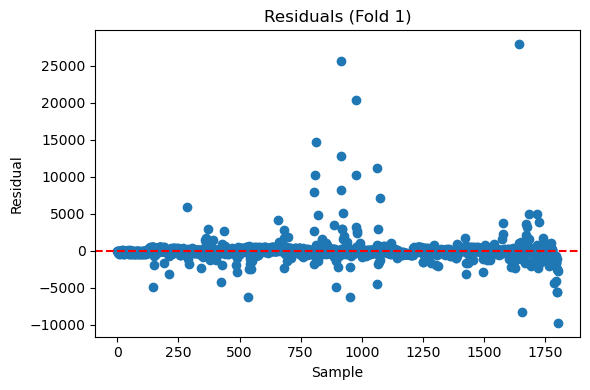

In [7]:
# ---------------- Análise de Resíduos (para a primeira fold) ----------------
plt.figure(figsize=(6,4))
plt.scatter(range(len(residuals_lr[0])), residuals_lr[0])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Fold 1)')
plt.xlabel('Sample')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

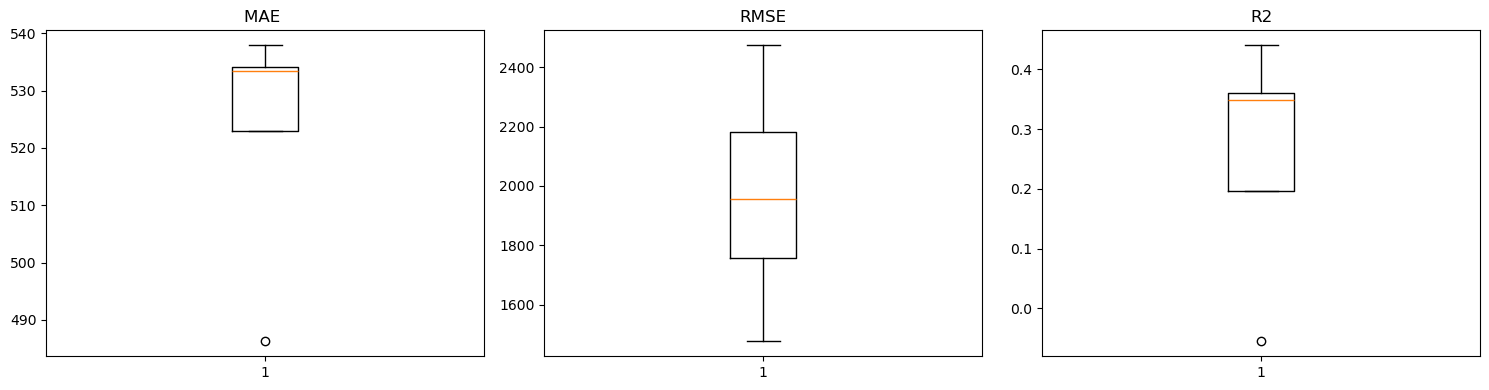

In [8]:
# ---------------- Visualização da Distribuição dos Erros ----------------
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].boxplot(mae_lr)
axs[0].set_title('MAE ')
axs[1].boxplot(rmse_lr)
axs[1].set_title('RMSE')
axs[2].boxplot(r2_lr)
axs[2].set_title('R2')
plt.tight_layout()
plt.show()

In [9]:
# ---------------- Coeficentes do Modelo de Regressão Linear ----------------
# Ajustar o modelo de regressão linear com todo o conjunto de dados
pipeline_lr.fit(X, y)
# Extrair os coeficientes do modelo
feature_names = (
    numeric_cols +
    list(pipeline_lr.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
)
coefs = pipeline_lr.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Separar coeficientes numéricos e categóricos
numeric_coef_df = coef_df[coef_df['Feature'].isin(numeric_cols)]
categorical_coef_df = coef_df[~coef_df['Feature'].isin(numeric_cols)]

# Ordenar coeficientes numéricos
categorical_coef_df['AbsCoefficient'] = categorical_coef_df['Coefficient'].abs()
categorical_coef_df = categorical_coef_df.sort_values(by='AbsCoefficient', ascending=False)

print("\nCoeficientes das variáveis numéricas:\n")
print(numeric_coef_df[['Feature', 'Coefficient']].to_string(index=False))

print("\nTop 10 coeficientes das variáveis categóricas:\n")
print(categorical_coef_df[['Feature', 'Coefficient']].head(10).to_string(index=False))


Coeficientes das variáveis numéricas:

                     Feature  Coefficient
         Affected_Population  1280.118894
         Populated_Area[km2]   136.028545
Air_Pollution_Average[ug/m3]  -235.763804

Top 10 coeficientes das variáveis categóricas:

        Feature  Coefficient
   NUTS_Code_ES -4237.242811
  NUTS_Code_ITC  2513.385363
 NUTS_Code_ITC4  2262.806118
   NUTS_Code_IT  1606.586401
   NUTS_Code_GR  1327.069382
  NUTS_Code_PT1 -1217.344348
   NUTS_Code_PT -1217.344348
NUTS_Code_ITC4C  1038.577336
  NUTS_Code_EL3   914.104780
 NUTS_Code_EL30   914.104780
